## <font color='green'> Word2Vec<font>

### <font color='green'> 1. Dataset Description<font>

The dataset used in this demo is Rotten Tomatoes movie review dataset. It is a corpus of movie reviews used majorly for sentiment analysis. It can be downloaded from [here](https://drive.google.com/file/d/1w1TsJB-gmIkZ28d1j7sf1sqcPmHXw352/view).

#### Import required libraries

In [1]:
# Importing some necessary libraries
import os
import time
import pandas as pd
import nltk
import numpy as np
import gensim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

### <font color='green'> 2. Data Preprocessing<font>

#### Loading RT review dataset

In [2]:
# download the dataset from below link (wget cannot be used bec it is google drive link)
# https://drive.google.com/file/d/1w1TsJB-gmIkZ28d1j7sf1sqcPmHXw352/view

In [3]:
# Load RT review dataset
data_file = "datasets/rt_reviews.csv"
df = pd.read_csv(data_file, encoding="ISO-8859-1")
df.shape

(480000, 2)

#### Dataset summary

In [4]:
# Dataset Analysis
print("Dataset contains {} reviews".format(df.shape[0]))
df.info()

Dataset contains 480000 reviews
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Freshness  480000 non-null  object
 1   Review     480000 non-null  object
dtypes: object(2)
memory usage: 7.3+ MB


#### Check top rows

In [5]:
df.head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


#### Drop the rows with na values and shuffle dataset

In [6]:
# Data Cleaning
df = df.dropna().sample(frac=1, random_state=42)
df.shape

(480000, 2)

#### Covert the reviews to lower case

In [7]:
df['Review'] = df['Review'].str.lower()
df

,Freshness,Review
312423,fresh,"guardians of the galaxy is first-class, grade..."
6849,rotten,"for a while, life aquatic gets mileage out of..."
361455,rotten,director ken scott stresses the movie's dude-...
5537,fresh,more a snapshot then a full blown insight int...
166017,fresh,the immigrant experience takes on a blacker-t...
...,...,...
259178,fresh,"at its best, with soviets, americans and raim..."
365838,rotten,just friends is a dumb teen comedy.
131932,rotten,fairly successful at faking some pretty cool ...
146867,fresh,the pacing misses a few beats and the satire ...


#### Remove Punctuation Marks

In [8]:
import re, string
def clean_review(review):
    pattern = re.compile(r'[^a-zA-Z0-9 ]')
    review = pattern.sub(' ', review)
    return review

In [9]:
import string
df['Review'] = df['Review'].apply(clean_review)
df

,Freshness,Review
312423,fresh,guardians of the galaxy is first class grade...
6849,rotten,for a while life aquatic gets mileage out of...
361455,rotten,director ken scott stresses the movie s dude ...
5537,fresh,more a snapshot then a full blown insight int...
166017,fresh,the immigrant experience takes on a blacker t...
...,...,...
259178,fresh,at its best with soviets americans and raim...
365838,rotten,just friends is a dumb teen comedy
131932,rotten,fairly successful at faking some pretty cool ...
146867,fresh,the pacing misses a few beats and the satire ...


#### Tokenize and Remove stopwords

In [10]:
# Tokenize and Remove Stop words
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: [item for item in word_tokenize(x) if item not in stop])
df

,Freshness,Review
312423,fresh,"[guardians, galaxy, first, class, grade, space..."
6849,rotten,"[life, aquatic, gets, mileage, quirkiness, pro..."
361455,rotten,"[director, ken, scott, stresses, movie, dude, ..."
5537,fresh,"[snapshot, full, blown, insight, either, vogue..."
166017,fresh,"[immigrant, experience, takes, blacker, black,..."
...,...,...
259178,fresh,"[best, soviets, americans, raimus, cross, purp..."
365838,rotten,"[friends, dumb, teen, comedy]"
131932,rotten,"[fairly, successful, faking, pretty, cool, stu..."
146867,fresh,"[pacing, misses, beats, satire, never, pops, d..."


#### Label distribution summary

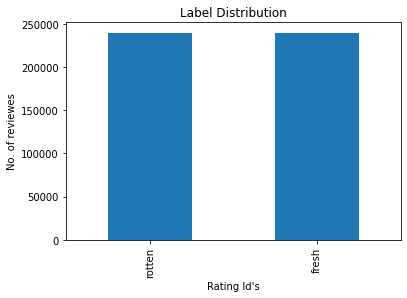

In [11]:
rating_categories = df["Freshness"].value_counts()
ax = rating_categories.plot(kind='bar', title='Label Distribution').\
     set(xlabel="Rating Id's", ylabel="No. of reviewes")

#### Encode the labels

In [12]:
mapping = {'fresh': 1, 'rotten': 0}
df['Freshness'] = df.replace({'Freshness': mapping})

#### Split train-test data

In [13]:
df_train, df_test = train_test_split(df, stratify=df["Freshness"], test_size=0.1, random_state = 42)
df_train = df_train.copy(deep=True)
df_test = df_test.copy(deep=True)

#### Check the shape of all the data

In [14]:
df_train.shape

(432000, 2)

In [15]:
df_test.shape

(48000, 2)

#### Set number of threads

In [16]:
os.environ["VE_OMP_NUM_THREADS"] = '8'
os.environ["VE_OMP_NUM_THREADS"]

'8'

### <font color='green'> 3. Logistic Regression using Gensim Word2Vec Embeddings<font>

#### Import Gensim Word2Vec

In [17]:
from gensim.models import Word2Vec as Gensim_Word2Vec

#### Generating word2vec embeddings for training vocabulary

In [18]:
time_start = time.time()

gensim_embeddings = Gensim_Word2Vec(df_train["Review"].to_list(), size=512, min_count=2, sg=1, iter=100)

time_stop = time.time()

#### Check time taken by gensim

In [19]:
gensim_elapsed_time = time_stop - time_start
gensim_elapsed_time

2372.7216968536377

#### Store the vocab for further use

In [20]:
gensim_vocab = gensim_embeddings.wv.vocab

#### Generating Train and Test Data Embeddings

In [21]:
no_embedding = np.zeros(gensim_embeddings.vector_size)

def document_vector_gensim(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    
    vocab_doc = [word for word in doc if word in gensim_vocab]
    
    if len(vocab_doc) != 0:
        return list(np.mean(gensim_embeddings.wv[vocab_doc], axis=0))
    else:
        return list(no_embedding)

In [22]:
df_train["Gensim_Embedding"] = df_train["Review"].apply(document_vector_gensim)

In [23]:
df_test["Gensim_Embedding"] = df_test["Review"].apply(document_vector_gensim)

#### Check the shape of all the data

In [24]:
df_train.shape

(432000, 3)

In [25]:
df_test.shape

(48000, 3)

#### Classification using gensim word2vec embeddings

In [26]:
# Training
model = LogisticRegression(max_iter=10000)
model.fit(df_train["Gensim_Embedding"].to_list(), df_train["Freshness"].to_list())

LogisticRegression(max_iter=10000)

In [27]:
# Train Score
gensim_train_score = model.score(df_train["Gensim_Embedding"].to_list(), df_train["Freshness"].to_list())
gensim_train_score

0.7754814814814814

In [28]:
# Test Score
gensim_test_score = model.score(df_test["Gensim_Embedding"].to_list(), df_test["Freshness"].to_list())
gensim_test_score

0.7710416666666666

### <font color='green'> 4. Logistic Regression using Frovedis Word2Vector Embeddings<font>

#### Initializing Frovedis Server

In [32]:
from frovedis.exrpc.server import FrovedisServer

FrovedisServer.initialize("mpirun -np 1 " + os.environ["FROVEDIS_SERVER"])

#### Generating word2vec embeddings for data

In [33]:
from frovedis.mllib import Word2Vec as Frovedis_Word2Vec

time_start = time.time()
frovedis_w2v = Frovedis_Word2Vec(df_train["Review"].to_list(), hiddenSize=512, minCount=2, n_iter=100)
time_stop = time.time()
#frovedis_w2v.build_vocab_and_dump(textfile, encode, vocab, count)

#### Check time taken by Frovedis

In [34]:
frovedis_elapsed_time = time_stop - time_start
frovedis_elapsed_time

104.39237999916077

#### Save w2v embeddings

In [35]:
model = "./out/rt_model.txt"
frovedis_w2v.save(model)

#### Check the embedings

In [36]:
list(frovedis_w2v.wv.keys())[:10]

['</s>',
 'film',
 'movie',
 'one',
 'like',
 'story',
 'much',
 'even',
 'good',
 'time']

In [37]:
frovedis_w2v.wv['film']

array([-6.16584904e-02, -1.79333016e-02,  1.27072315e-04, -1.36971520e-02,
        8.89550075e-02,  2.20617298e-02, -1.20351315e-01, -6.16060570e-02,
        8.30795616e-02, -1.04777984e-01,  4.18959446e-02, -8.43611360e-02,
        8.53607580e-02, -9.96442586e-02,  3.82825769e-02,  1.63230449e-01,
       -7.22117871e-02,  2.28723362e-01,  1.54013231e-01,  3.30435447e-02,
        7.09022060e-02,  1.23819327e-02, -4.12228554e-02, -2.60384288e-02,
       -8.71949941e-02,  6.83157966e-02, -7.39157870e-02, -2.15297982e-01,
        7.42161348e-02,  2.72165090e-02,  3.45337093e-02,  1.23983763e-01,
       -2.20355149e-02,  7.72373155e-02,  8.90648067e-02,  4.04726863e-02,
        1.93865485e-02, -2.01683477e-01, -3.57436650e-02, -1.89387411e-01,
        2.60237083e-02,  1.15786055e-02,  3.84637192e-02, -6.14178665e-02,
       -1.56340431e-02,  1.15998901e-01, -1.08585313e-01,  6.01873174e-02,
        1.71462432e-01,  4.78881150e-02, -3.04641575e-01,  5.34929894e-02,
       -8.51864964e-02, -

In [38]:
print("Embeddings are of shape ({0}, {1})".format(len(frovedis_w2v.wv.keys()),\
                                           len(frovedis_w2v.wv['film'])))

Embeddings are of shape (61775, 512)


#### Generating Train and Test Data Embeddings

In [39]:
df_train["Frovedis_Embedding"] = list(frovedis_w2v.transform(df_train["Review"].to_list(), func=np.mean))

In [40]:
df_test["Frovedis_Embedding"] = list(frovedis_w2v.transform(df_test["Review"].to_list(), func=np.mean))

#### Classification using frovedis word2vec embeddings

In [41]:
# Training
model = LogisticRegression(max_iter=10000)
model.fit(df_train["Frovedis_Embedding"].to_list(), df_train["Freshness"].to_list())

LogisticRegression(max_iter=10000)

In [42]:
# Train Score
frov_train_score = model.score(df_train["Frovedis_Embedding"].to_list(), df_train["Freshness"].to_list())
frov_train_score

0.7763217592592593

In [43]:
# Test Score
frov_test_score = model.score(df_test["Frovedis_Embedding"].to_list(), df_test["Freshness"].to_list())
frov_test_score

0.77225

### Shutting Down Frovedis Server

In [44]:
FrovedisServer.shut_down()

### <font color='green'> 5. Results Comparison<font>

In [45]:
# Training Time
print ("Frovedis train time : {:.3f} sec".format(frovedis_elapsed_time))
print ("Gensim train time : {:.3f} sec".format(gensim_elapsed_time))

Frovedis train time : 104.392 sec
Gensim train time : 2372.722 sec


In [46]:
# Score
print('LogisticRegression score using Frovedis word2vec embeddings : '+ str(frov_test_score))
print('LogisticRegression score using Gensim word2vec embeddings : '+ str(gensim_test_score))

LogisticRegression score using Frovedis word2vec embeddings : 0.77225
LogisticRegression score using Gensim word2vec embeddings : 0.7710416666666666
